In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as func
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

#Matplotlib figürleri için beyaz bir arka plan kullanın
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
#Kalıp
#transform = transforms.Compose(
#    [transforms.ToTensor()])

In [3]:
dataset = MNIST(root = 'data/', download = True, transform = ToTensor())

image shape: torch.Size([1, 28, 28])
label: 5


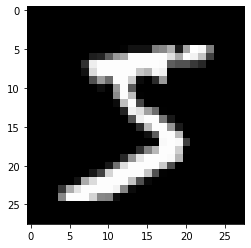

In [4]:
image, label = dataset[0]
print("image shape:", image.shape)
plt.imshow(image.permute(1, 2, 0), cmap = 'gray');# kanalların bir görüntü tensöründe son boyut olmasını bekler, bu nedenle görüntünün boyutlarını yeniden düzenlemek için permute yöntemini kullanırız.
print('label:',label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

In [6]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [7]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True) 
val_loader = DataLoader(val_ds, 2 * batch_size, num_workers = 4, pin_memory = True) 

images.shape: torch.Size([128, 1, 28, 28])


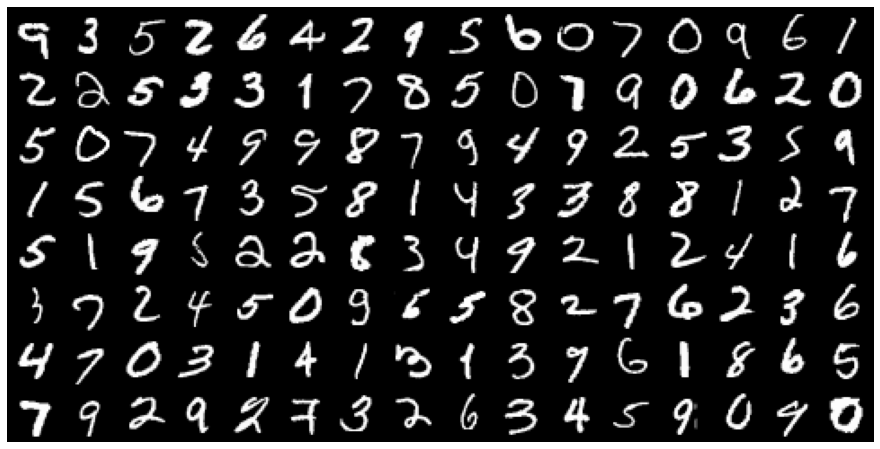

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

İki katmanlı bir sinir ağı oluşturacağız: gizli bir katman ve bir çıktı katmanı. Ek olarak, iki katman arasında bir aktivasyon işlevi kullanacağız. Gizli katmanların ve etkinleştirme işlevlerinin girdiler ve çıktılar arasındaki doğrusal olmayan ilişkileri yakalamaya nasıl yardımcı olabileceğini öğrenmek için adım adım bir örneğe bakalım.

İlk olarak, bir dizi girdi tensörü oluşturalım. 1x28x28 görselleri 784 boyutunda vektörler halinde düzleştireceğiz, böylece nn.Linear nesnesine geçirilebilirler.

In [9]:
for images, labels in train_loader:
    print('İmages Shape:',images.shape)
    inputs = images.reshape(-1,784)
    print('İnputs Shape', inputs.shape)
    break

İmages Shape: torch.Size([128, 1, 28, 28])
İnputs Shape torch.Size([128, 784])


In [10]:
input_size = inputs.shape[-1]
hidden_size = 32

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape#giriş verilerimizin boyutu 128 resim her resimde 784 pixel

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
layer1_outputs.shape#ara katman çıkışında 128 resimin 32 çıkış değeri olmuştur

torch.Size([128, 32])

In [14]:
print('Layer1 Outputs Shape :', layer1_outputs.shape)

Layer1 Outputs Shape : torch.Size([128, 32])


784 boyutundaki görüntü vektörleri, layer1'in transpoze ağırlık matrisi ile girdi matrisinin bir matris çarpımı gerçekleştirerek ve önyargı ekleyerek 32 uzunluğundaki ara çıktı vektörlerine dönüştürülür. Bunu torch.allclose kullanarak doğrulayabiliriz. Daha ayrıntılı bir açıklama için, doğrusal regresyon hakkındaki eğiticiyi inceleyin.

In [15]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias#üstteki linear işlem ile aynı işlemi yaptık
layer1_outputs_direct.shape

torch.Size([128, 32])

In [16]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)# iki değerlerinde aynı olup olmadığını kontrol ettik

True

Bu nedenle, layer1_outputs ve inputs doğrusal bir ilişkiye sahiptir, yani, layer1_outputs öğelerinin her bir öğesi, girdilerden alınan öğelerin ağırlıklı bir toplamıdır. Bu nedenle, modeli eğitip ağırlıkları değiştirsek bile, layer1 yalnızca girdiler ve çıktılar arasındaki doğrusal ilişkileri yakalayabilir.

Ardından, çıktılar için etkinleştirme işlevi olarak Doğrultulmuş Doğrusal Birim (ReLU) işlevini kullanacağız. Relu (x) = max (0, x) formülüne sahiptir, yani belirli bir tensördeki negatif değerleri 0 değeriyle değiştirir. ReLU, burada görsel olarak görüldüğü gibi doğrusal olmayan bir fonksiyondur:

ReLU'yu bir tensörün elemanlarına uygulamak için F.relu yöntemini kullanabiliriz.

Yani kısaca bu gizli katmandan çıkan değerleri relu fonksiyonuna yollayarak doğrusal olamyan fonksiyon ile yeni çıkışlar elde ederiz çıkış katmanına bu değerler yollanır

In [17]:
#RELU deneme işlemi
func.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Etkinleştirme işlevini layer1_outputs'a uygulayalım ve negatif değerlerin 0 ile değiştirildiğini doğrulayalım.

In [18]:
relu_outputs = func.relu(layer1_outputs)

In [19]:
print('min(layer1_outputs):',torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs[0]).item())#görüldüpü gibi relu snucu min değerler 0 oldu

min(layer1_outputs): -0.7774189710617065
min(relu_outputs): 0.0


Artık doğrusal olmayan bir etkinleştirme işlevi uyguladığımıza göre, relu_outputs ve girdilerin doğrusal bir ilişkisi yok. ReLU'ya aktivasyon fonksiyonu olarak atıfta bulunuyoruz, çünkü her giriş için belirli çıkışlar etkinleştirilirken (sıfır olmayan değerlere sahip olanlar) diğerleri kapatılırken (sıfır değerleri olanlar)

Daha sonra, relu_outputs içindeki hidden_size uzunluktaki vektörleri modelimizin istenen çıktısı olan 10 uzunluklu vektörlere dönüştürmek için bir çıktı katmanı oluşturalım (10 hedef etiket olduğundan).

In [20]:
output_size = 10

In [21]:
print(hidden_size)
print(output_size)

32
10


In [22]:
layer2 = nn.Linear(hidden_size, output_size)

In [23]:
layer2_outputs = layer2(relu_outputs)

In [24]:
layer2_outputs.shape

torch.Size([128, 10])

Beklendiği gibi, layer2_outputs 10 büyüklüğünde bir grup vektör içerir. Şimdi bu çıktıyı F.cross_entropy kullanarak kaybı hesaplamak ve gradyan inişini kullanarak katman1 ve katman2'nin ağırlıklarını ayarlamak için kullanabiliriz.

In [25]:
func.cross_entropy(layer2_outputs, labels)

tensor(2.3071, grad_fn=<NllLossBackward>)

Böylece, modelimiz doğrusal bir transformation  uygulayarak (layer1 kullanarak), ardından doğrusal olmayan bir activation fonksiyonu (F.relu kullanarak) ve ardından başka bir doğrusal transformation  (layer2 kullanarak) uygulayarak girdileri layer2 çıktılarına dönüştürür. Çıkışı temel matris işlemlerini kullanarak yeniden hesaplayarak bunu doğrulayalım.

In [26]:
#Bir doğrulama işlemi daha 
outputs = (func.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [27]:
torch.allclose(layer2_outputs, outputs, 1e-3)#görüldüğü gibi benzer çıktı

True

Doğrusal olmayan etkinleştirme işlevi F.relu nedeniyle çıktıların ve girdilerin doğrusal bir ilişkisi olmadığını unutmayın. Modeli eğitirken ve layer1 ve layer2'nin ağırlıklarını ayarlarken, artık görüntüler ve etiketleri arasındaki doğrusal olmayan ilişkileri yakalayabiliriz. Başka bir deyişle, doğrusal olmama durumu, modeli daha güçlü ve çok yönlü hale getirir. Ayrıca, hidden_size girdilerin veya çıktıların boyutlarına bağlı olmadığından, model içindeki parametre sayısını artırmak için onu değiştiriyoruz. Ayrıca yeni gizli katmanlar ekleyebilir ve her gizli katmandan sonra aynı doğrusal olmayan etkinleştirmeyi uygulayabiliriz.

Az önce yarattığımız modelin adı sinir ağı. Derin bir sinir ağı, bir veya daha fazla gizli katmana sahip bir sinir ağıdır. Aslında, Evrensel Yaklaşım Teoremi, yeterince büyük ve derin bir sinir ağının herhangi bir keyfi işlevi hesaplayabileceğini, yani girdiler ve hedefler arasındaki zengin ve karmaşık doğrusal olmayan ilişkileri öğrenebileceğini belirtir. İşte bazı örnekler:

--Bir görüntünün kedi veya köpek (veya başka bir şey) içerip içermediğini belirleme

--10 saniyelik bir örnek kullanarak bir şarkının türünü belirleme

--Film eleştirilerini içeriklerine göre olumlu veya olumsuz olarak sınıflandırmak

--Yolun video beslemesini kullanarak sürücüsüz arabalarda gezinme

--Cümleleri İngilizceden Fransızcaya (ve diğer yüzlerce dile) çevirme

--Bir konuşma kaydını metne dönüştürme ve bunun tersi

--Ve daha fazlası...


Girdileri rastgele başlatılmış matrislerle çarpma, doğrusal olmayan aktivasyonlar uygulama ve gradyan iniş kullanarak tekrar tekrar ağırlık ayarlama işleminin nasıl şaşırtıcı sonuçlar verebileceğini hayal etmek zor. Derin öğrenme modelleri genellikle insan beyninin kavrayabileceğinden çok daha karmaşık ilişkileri yakalayabilen milyonlarca parametre içerir.

İki doğrusal katman arasına doğrusal olmayan bir aktivasyon dahil etmemiş olsaydık, girdiler ve çıktılar arasındaki son ilişki yine doğrusal olurdu. Hesaplamaların basit bir şekilde yeniden düzenlenmesi bunu göstermektedir.

Arada kullanılan aktivasyon fonksiyonu bizim doğrusal olan ağımızı doğrusal olmayan çevirir

## MODEL

In [28]:
class MnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        #hidden layer output
        out = self.linear1(xb)
        #hidden layer relu function
        out = func.relu(out)
        #output layer output
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = func.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = func.cross_entropy(out, labels) 
        acc = accuracy(out, labels)
        return {'val_acc' : acc, 'val_loss' : loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_acc': epoch_acc.item(), 'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch[{}], val_loss:{:.4f}, val_acc:{:.4f}'.format(epoch, result['val_loss'], result['val_acc']))

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
input_size = 784
hidden_size = 32
output_size = 10

In [31]:
model = MnistModel(input_size, hidden_size, output_size)

In [32]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [33]:
for images, labels in train_loader:
    outputs = model(images)
    loss = func.cross_entropy(outputs, labels)
    print("Loss:", loss.item())
    break
    
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3172519207000732
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0196, -0.0216,  0.0847, -0.0316,  0.0420,  0.1236, -0.2853, -0.0954,
          0.0832, -0.1034],
        [-0.0751,  0.0736, -0.0197,  0.0856,  0.1618,  0.0452,  0.0554, -0.0689,
         -0.0897,  0.1491]])


In [34]:
torch.cuda.is_available()

True

In [35]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
def to_device(data, device):#tensorları gpu ya taşıyoruz
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [38]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [39]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Python'daki getiri anahtar sözcüğü, aşağıda gösterildiği gibi bir for döngüsü içinde kullanılabilecek bir üretici işlevi oluşturmak için kullanılır.

Artık veri yükleyicilerimizi DeviceDataLoader kullanarak sarmalayabiliriz.

In [40]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [41]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([2, 1, 0, 3, 0, 8, 5, 8, 6, 6, 0, 9, 5, 4, 4, 2, 3, 1, 6, 3, 8, 1, 1, 2,
        8, 0, 6, 7, 9, 8, 4, 3, 5, 9, 2, 7, 3, 3, 8, 8, 1, 1, 2, 4, 9, 5, 3, 7,
        4, 7, 1, 8, 9, 3, 1, 7, 7, 8, 6, 7, 1, 7, 8, 3, 5, 8, 6, 2, 6, 1, 0, 2,
        6, 9, 8, 2, 3, 6, 5, 4, 6, 4, 4, 1, 6, 0, 4, 6, 1, 4, 9, 8, 6, 9, 9, 6,
        6, 6, 6, 5, 6, 6, 5, 1, 2, 4, 6, 1, 7, 5, 5, 6, 1, 8, 4, 3, 3, 6, 5, 9,
        4, 9, 7, 1, 2, 5, 0, 3, 5, 3, 8, 9, 6, 7, 3, 8, 1, 2, 7, 1, 6, 2, 7, 5,
        6, 9, 5, 5, 6, 0, 1, 9, 7, 7, 5, 7, 2, 4, 8, 5, 3, 6, 9, 4, 9, 3, 1, 9,
        1, 2, 4, 5, 2, 4, 9, 9, 6, 7, 5, 3, 0, 9, 5, 6, 1, 1, 0, 8, 2, 2, 3, 4,
        8, 9, 6, 8, 3, 3, 0, 9, 1, 9, 2, 8, 0, 0, 6, 2, 1, 4, 1, 2, 3, 9, 1, 3,
        8, 3, 2, 7, 1, 1, 2, 2, 2, 2, 7, 3, 9, 6, 5, 9, 0, 6, 3, 9, 0, 0, 4, 1,
        9, 7, 7, 8, 7, 4, 2, 3, 8, 5, 4, 3, 6, 1, 4, 1], device='cuda:0')


## Training the Model

İki işlevi tanımlayacağız: modeli gradyan inişini kullanarak eğitmek için sığdırın ve değerlendirin ve doğrulama setindeki performansını değerlendirin. Bu işlevlerin ayrıntılı bir incelemesi için önceki eğiticiye göz atın.

In [42]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [43]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Modeli eğitmeden önce, verilerin ve modelin parametrelerinin (ağırlıklar ve önyargılar) aynı cihazda (CPU veya GPU) olduğundan emin olmamız gerekir. Modelin parametrelerini doğru cihaza taşımak için to_device işlevini yeniden kullanabiliriz.

In [44]:
model = MnistModel(input_size, hidden_size, output_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Modelin, başlangıç ​​ağırlıkları ve önyargıları ile doğrulama setinde nasıl performans gösterdiğini görelim.

In [45]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.11533202975988388, 'val_loss': 2.313817262649536}]

In [46]:
history += fit(20, 0.01, model, train_loader, val_loader)

Epoch[0], val_loss:1.3757, val_acc:0.7312
Epoch[1], val_loss:0.7510, val_acc:0.8255
Epoch[2], val_loss:0.5708, val_acc:0.8572
Epoch[3], val_loss:0.4878, val_acc:0.8757
Epoch[4], val_loss:0.4420, val_acc:0.8836
Epoch[5], val_loss:0.4128, val_acc:0.8918
Epoch[6], val_loss:0.3915, val_acc:0.8941
Epoch[7], val_loss:0.3763, val_acc:0.8977
Epoch[8], val_loss:0.3633, val_acc:0.9007
Epoch[9], val_loss:0.3546, val_acc:0.9020
Epoch[10], val_loss:0.3448, val_acc:0.9039
Epoch[11], val_loss:0.3383, val_acc:0.9073
Epoch[12], val_loss:0.3316, val_acc:0.9081
Epoch[13], val_loss:0.3259, val_acc:0.9087
Epoch[14], val_loss:0.3193, val_acc:0.9106
Epoch[15], val_loss:0.3149, val_acc:0.9122
Epoch[16], val_loss:0.3099, val_acc:0.9130
Epoch[17], val_loss:0.3047, val_acc:0.9140
Epoch[18], val_loss:0.3010, val_acc:0.9152
Epoch[19], val_loss:0.2974, val_acc:0.9169


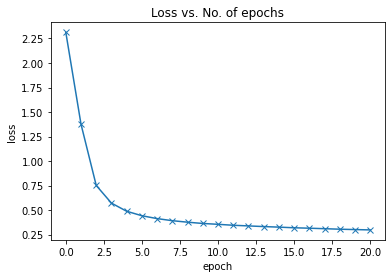

In [47]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Text(0.5, 1.0, 'Acc vs. No. of epochs')

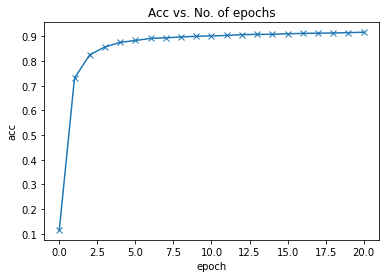

In [48]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Acc vs. No. of epochs')

## Testing with individual images


In [51]:
test_dataset = MNIST(root = 'data/', train = False, transform = ToTensor())

In [52]:
len(test_dataset)

10000

In [54]:
img, label = test_dataset[0]

Shape: torch.Size([1, 28, 28])
Label: 7


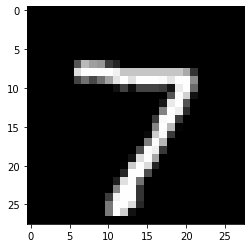

In [55]:
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [58]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return preds[0].item()

label: 7 predict: 7


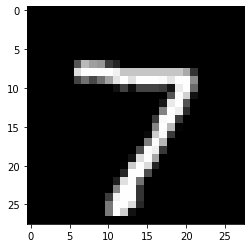

In [61]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('label:', label, 'predict:', predict_image(img[0], model))


Label: 2 , Predicted: 2


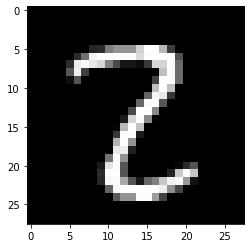

In [62]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 8 , Predicted: 8


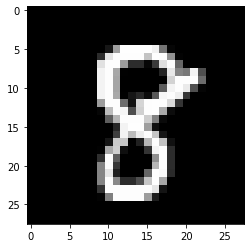

In [63]:
img, label = test_dataset[8566]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


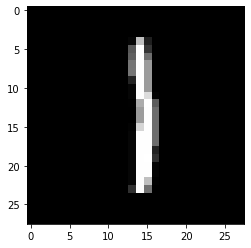

In [64]:
img, label = test_dataset[154]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [66]:
test_dataloader = DeviceDataLoader(DataLoader(test_dataset, batch_size = 256), device) 

In [69]:
result = evaluate(model, test_dataloader)
result

{'val_acc': 0.9239257574081421, 'val_loss': 0.26707324385643005}

In [70]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_loss'])

[jovian] Metrics logged.


In [ ]:
torch.save(model.state_dict())

In [74]:
model2 = MnistModel(input_size, hidden_size, output_size)

In [76]:
model2.load_state_dict(torch.load('mnist-feedforward.pth'))

<All keys matched successfully>

In [78]:
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.0320,  0.0222,  0.0169,  ...,  0.0274, -0.0335, -0.0292],
                      [ 0.0178, -0.0285,  0.0177,  ...,  0.0315, -0.0278, -0.0288],
                      [ 0.0323, -0.0006, -0.0151,  ..., -0.0088,  0.0207, -0.0330],
                      ...,
                      [ 0.0107,  0.0245, -0.0157,  ..., -0.0186,  0.0059,  0.0323],
                      [-0.0330,  0.0221, -0.0097,  ...,  0.0184,  0.0338, -0.0184],
                      [ 0.0332,  0.0102,  0.0300,  ...,  0.0234, -0.0311, -0.0227]])),
             ('linear1.bias',
              tensor([ 0.0467,  0.2567, -0.0029, -0.0813,  0.0705, -0.0008,  0.2792,  0.0194,
                      -0.1554,  0.0796,  0.0387,  0.0315, -0.0148,  0.1183,  0.0769, -0.1292,
                       0.0637,  0.0400,  0.1278, -0.0206,  0.1539,  0.1664, -0.1031,  0.1708,
                      -0.0404,  0.0140, -0.0621,  0.1195, -0.0800,  0.1102,  0.1639,  0.1019])),
             ('linear2.we

In [79]:
import jovian
jovian.commit(project='04-feedforward-nn')


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "tolgaisikp/04-feedforward-nn" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tolgaisikp/04-feedforward-nn


'https://jovian.ai/tolgaisikp/04-feedforward-nn'